In [43]:
#import packages

import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import scipy.stats as stats
import networkx as nx
from operator import itemgetter
from networkx.algorithms import community
from community import community_louvain
from nxviz import utils
from tqdm import tqdm
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

import seaborn as sns; sns.set(style="ticks", context = "paper", font = "Arial", font_scale = 1.9,
                               palette='colorblind', color_codes = True,
                               rc = {"font.size":7,
                                     "xtick.major.size": 2,
                                     "ytick.major.size": 2})
import warnings
warnings.filterwarnings('ignore')

In [54]:
# sum cfos density/vol

def sum_cfos_density (genotype, st_pattern):
    """formation of reference_list of all sample in a particular genotype"""

    structure_path = "quantification/"+ genotype+"/"+st_pattern
    column_name = []
    sum_L_all = []
    sum_R_all = []

    for root, dirs, files in os.walk (structure_path):
        for file in files:
            if file.endswith ("rre_cfos_L_summary.csv"):#data will be avaiable after publication
                file_l_path = os.path.join(root, "rre_cfos_L_summary.csv")
                folder_path = os.path.dirname(file_l_path)
                path,folder_name = os.path.split(folder_path)
                column_name.append (folder_name)
                YFP_L = pd.read_csv (file_l_path, index_col = 0)
                YFP_sum_L = []
                file_al_path = os.path.join(root, "rre_area_L_summary.csv")#data will be avaiable after publication
                area_L = (pd.read_csv (file_al_path, index_col = 0))*(1.76**2)/1000000
                total_YFP_L = YFP_L*area_L

                for index_l, vara_l in total_YFP_L.iterrows():
                    sum_l = sum (total_YFP_L[total_YFP_L >=0].loc[index_l].dropna().values)
                    sum_area_l = sum (area_L[area_L >= 0].loc[index_l].dropna().values)*0.06
                    if sum_area_l >0:
                        YFP_mean_l = sum_l/sum_area_l
                    else:
                        YFP_mean_l=np.nan
                    YFP_sum_L.append (YFP_mean_l)
                sum_L_all.append(YFP_sum_L)

                YFP_R = pd.read_csv (os.path.join(root, "rre_cfos_R_summary.csv"), index_col = 0)#data will be avaiable after publication
                YFP_sum_R = []
                file_ar_path = os.path.join(root, "rre_area_R_summary.csv")#data will be avaiable after publication
                area_R = (pd.read_csv (file_ar_path, index_col = 0))*(1.76**2)/1000000
                total_YFP_R = YFP_R*area_R

                for index_r, vara_r in total_YFP_R.iterrows():
                    sum_r = sum (total_YFP_R[total_YFP_R >=0].loc[index_r].dropna().values)
                    sum_area_r = sum (area_R[area_R >= 0].loc[index_r].dropna().values)*0.06
                    if sum_area_r >0:
                        YFP_mean_r = sum_r/sum_area_r
                    else:
                        YFP_mean_r = np.nan                        
                    YFP_sum_R.append (YFP_mean_r)
                sum_R_all.append(YFP_sum_R)

    pd_YFP_l = pd.DataFrame (data = np.transpose (sum_L_all), index = total_YFP_L.index, columns = column_name)
    pd_YFP_r = pd.DataFrame (data = np.transpose (sum_R_all), index = total_YFP_R.index, columns = column_name)

    return (pd_YFP_l, pd_YFP_r)
 
W_cfos_L_ctrl, W_cfos_R_ctrl = sum_cfos_density ("WT", "ctrl")
W_cfos_L_TBS, W_cfos_R_TBS = sum_cfos_density ("WT", "TBS")
T_cfos_L_ctrl, T_cfos_R_ctrl = sum_cfos_density ("Tbr1", "ctrl")
T_cfos_L_TBS, T_cfos_R_TBS = sum_cfos_density ("Tbr1", "TBS")

W_cfos_L_TBS_raw = W_cfos_L_TBS.dropna().copy()
W_cfos_R_TBS_raw = W_cfos_R_TBS.dropna().copy()
W_cfos_L_ctrl_raw = W_cfos_L_ctrl.dropna().copy()
W_cfos_R_ctrl_raw = W_cfos_R_ctrl.dropna().copy()

T_cfos_L_TBS_raw = T_cfos_L_TBS.dropna().copy()
T_cfos_R_TBS_raw = T_cfos_R_TBS.dropna().copy()
T_cfos_L_ctrl_raw = T_cfos_L_ctrl.dropna().copy()
T_cfos_R_ctrl_raw = T_cfos_R_ctrl.dropna().copy()

W_cfos_L_TBS_raw["average"] = W_cfos_L_TBS_raw[W_cfos_L_TBS_raw>=0].mean(axis = 1)
W_cfos_R_TBS_raw["average"] = W_cfos_R_TBS_raw[W_cfos_R_TBS_raw>=0].mean(axis = 1)
W_cfos_L_ctrl_raw["average"] = W_cfos_L_ctrl_raw[W_cfos_L_ctrl_raw>=0].mean(axis = 1)
W_cfos_R_ctrl_raw["average"] = W_cfos_R_ctrl_raw[W_cfos_R_ctrl_raw>=0].mean(axis = 1)

T_cfos_L_TBS_raw["average"] = T_cfos_L_TBS_raw[T_cfos_L_TBS_raw>=0].mean(axis = 1)
T_cfos_R_TBS_raw["average"] = T_cfos_R_TBS_raw[T_cfos_R_TBS_raw>=0].mean(axis = 1)
T_cfos_L_ctrl_raw["average"] = T_cfos_L_ctrl_raw[T_cfos_L_ctrl_raw>=0].mean(axis = 1)
T_cfos_R_ctrl_raw["average"] = T_cfos_R_ctrl_raw[T_cfos_R_ctrl_raw>=0].mean(axis = 1)

average_sum_L = W_cfos_L_TBS_raw["average"]+W_cfos_L_ctrl_raw["average"]+T_cfos_L_TBS_raw["average"]+T_cfos_L_ctrl_raw["average"]
average_sum_R = W_cfos_R_TBS_raw["average"]+W_cfos_R_ctrl_raw["average"]+T_cfos_R_TBS_raw["average"]+T_cfos_R_ctrl_raw["average"]

#filter structure based on cfos average sum density of 4 conditions
cfos_structure_L = average_sum_L[average_sum_L>=800].index.tolist()
cfos_structure_R = average_sum_R[average_sum_R>=800].index.tolist()


#normalize to WT ctrl average cfos signal
W_cfos_L_ctrl["average"]= W_cfos_L_ctrl[W_cfos_L_ctrl >= 0].mean(axis = 1)
W_cfos_R_ctrl["average"]= W_cfos_R_ctrl[W_cfos_R_ctrl >= 0].mean(axis = 1)
W_cfos_L_TBS["WT nost average"]= W_cfos_L_ctrl[W_cfos_L_ctrl >= 0].mean(axis = 1)
W_cfos_R_TBS["WT nost average"]= W_cfos_R_ctrl[W_cfos_R_ctrl >= 0].mean(axis = 1)
T_cfos_L_TBS["WT nost average"] = W_cfos_L_ctrl[W_cfos_L_ctrl >= 0].mean(axis = 1)
T_cfos_L_ctrl["WT nost average"] = W_cfos_L_ctrl[W_cfos_L_ctrl >= 0].mean(axis = 1)
T_cfos_R_TBS["WT nost average"] = W_cfos_R_ctrl[W_cfos_L_ctrl >= 0].mean(axis = 1)
T_cfos_R_ctrl["WT nost average"] = W_cfos_R_ctrl[W_cfos_L_ctrl >= 0].mean(axis = 1)

for indexg, varag in W_cfos_L_TBS.iterrows():
    
    W_cfos_L_TBS.loc[indexg] = (W_cfos_L_TBS.loc[indexg] / W_cfos_L_ctrl["average"].loc[indexg])*100
    W_cfos_L_ctrl.loc[indexg] = (W_cfos_L_ctrl.loc[indexg] / W_cfos_L_ctrl["average"].loc[indexg])*100
    W_cfos_R_TBS.loc[indexg] = (W_cfos_R_TBS.loc[indexg] / W_cfos_R_ctrl["average"].loc[indexg])*100
    W_cfos_R_ctrl.loc[indexg] = (W_cfos_R_ctrl.loc[indexg] / W_cfos_R_ctrl["average"].loc[indexg])*100
    
for indexh, varah in T_cfos_L_TBS.iterrows():
    T_cfos_L_TBS.loc[indexh] = (T_cfos_L_TBS.loc[indexh] / T_cfos_L_TBS["WT nost average"].loc[indexh])*100
    T_cfos_L_ctrl.loc[indexh] = (T_cfos_L_ctrl.loc[indexh] / T_cfos_L_ctrl["WT nost average"].loc[indexh])*100
    T_cfos_R_TBS.loc[indexh] = (T_cfos_R_TBS.loc[indexh] /T_cfos_R_TBS["WT nost average"].loc[indexh])*100
    T_cfos_R_ctrl.loc[indexh] = (T_cfos_R_ctrl.loc[indexh] / T_cfos_R_ctrl["WT nost average"].loc[indexh])*100


W_cfos_L_TBS_re=W_cfos_L_TBS.loc[cfos_structure_L].T[:-1]
W_cfos_R_TBS_re=W_cfos_R_TBS.loc[cfos_structure_R].T[:-1]
W_cfos_L_ctrl_re=W_cfos_L_ctrl.loc[cfos_structure_L].T[:-1]
W_cfos_R_ctrl_re=W_cfos_R_ctrl.loc[cfos_structure_R].T[:-1]
T_cfos_L_TBS_re=T_cfos_L_TBS.loc[cfos_structure_L].T[:-1]
T_cfos_R_TBS_re=T_cfos_R_TBS.loc[cfos_structure_R].T[:-1]
T_cfos_L_ctrl_re=T_cfos_L_ctrl.loc[cfos_structure_L].T[:-1]
T_cfos_R_ctrl_re=T_cfos_R_ctrl.loc[cfos_structure_R].T[:-1]

In [70]:
#subset brain regions for analysis

W_cfos_L_TBS_re["Group"] = "WT_TBS"
W_cfos_R_TBS_re["Group"] = "WT_TBS"
W_cfos_L_ctrl_re["Group"] = "WT_ctrl"
W_cfos_R_ctrl_re["Group"] = "WT_ctrl"
T_cfos_L_TBS_re["Group"] = "Tbr1_TBS"
T_cfos_R_TBS_re["Group"] = "Tbr1_TBS"
T_cfos_L_ctrl_re["Group"] = "Tbr1_ctrl"
T_cfos_R_ctrl_re["Group"] = "Tbr1_ctrl"

cfos_L = pd.concat([W_cfos_L_ctrl_re, T_cfos_L_ctrl_re, W_cfos_L_TBS_re, T_cfos_L_TBS_re])
cfos_R = pd.concat([W_cfos_R_ctrl_re, T_cfos_R_ctrl_re, W_cfos_R_TBS_re, T_cfos_R_TBS_re])

#subset brain regions
structure_list_parent_v1 = pd.read_csv ("CCFv3/structuretree/structure_list_paper_cfos.csv", index_col = 0)

def subseting_structure_cfos (pd, structure_list):
    """subseting parent or offspring brain structures"""
    pd_sub = pd[[a for a in  structure_list.LABEL.values if a in pd.columns]]

    return pd_sub

parent_cfos_L = subseting_structure_cfos(cfos_L, structure_list_parent_v1)
parent_cfos_R = subseting_structure_cfos(cfos_R, structure_list_parent_v1)


In [71]:
#correlation analysis

for a in parent_cfos_L.columns:
    parent_cfos_L.rename (columns = {a: (str ("c_")+a)}, inplace = True)

for b in parent_cfos_R.columns:
    parent_cfos_R.rename (columns = {b: (str ("i_")+b)}, inplace = True)
    

parent_cfos_all = pd.concat ([parent_cfos_R, parent_cfos_L], axis = 1)
parent_cfos_all["Group"] = cfos_L.Group

#calculate correlation martix P values and correlation values (kendalltau)
def correlation_P_C_kendalltau (df):
    """formation of significance martix and correlation martix by stats.kendalltau"""
    P_maxtrix =pd.DataFrame(np.empty ([len(df.columns)-1,len(df.columns)-1], dtype=float), 
                                columns = df.columns.tolist()[:-1],
                                index = df.columns.tolist()[:-1])
    C_maxtrix = P_maxtrix.copy()
    for a in P_maxtrix.columns:
        for b in P_maxtrix.columns:
            c = stats.kendalltau (df[a].values.reshape(-1,1), df[b].values.reshape(-1,1))[0]
            p = stats.kendalltau (df[a].values.reshape(-1,1), df[b].values.reshape(-1,1))[1]
            P_maxtrix.loc[a,b] = p
            C_maxtrix.loc[a,b] = c

    return P_maxtrix, C_maxtrix

P_WT_ctrl, R_WT_ctrl = correlation_P_C_kendalltau (parent_cfos_all[parent_cfos_all["Group"]== "WT_ctrl"])
P_Tbr1_ctrl, R_Tbr1_ctrl = correlation_P_C_kendalltau (parent_cfos_all[parent_cfos_all["Group"]== "Tbr1_ctrl"])
P_WT_TBS, R_WT_TBS = correlation_P_C_kendalltau (parent_cfos_all[parent_cfos_all["Group"]== "WT_TBS"])
P_Tbr1_TBS, R_Tbr1_TBS = correlation_P_C_kendalltau (parent_cfos_all[parent_cfos_all["Group"]== "Tbr1_TBS"])

In [72]:
#saving correlation results for further analysis

correlation_folder = "correlation"
if not os.path.exists(correlation_folder):
    os.makedirs(correlation_folder)

P_WT_ctrl.to_csv (correlation_folder+"/P_WT_ctrl.csv")
P_Tbr1_ctrl.to_csv (correlation_folder+"/P_Tbr1_ctrl.csv")
P_WT_TBS.to_csv (correlation_folder+"/P_WT_TBS.csv")
P_Tbr1_TBS.to_csv (correlation_folder+"/P_Tbr1_TBS.csv")

R_WT_ctrl.to_csv (correlation_folder+"/R_WT_ctrl.csv")
R_Tbr1_ctrl.to_csv (correlation_folder+"/R_Tbr1_ctrl.csv")
R_WT_TBS.to_csv (correlation_folder+"/R_WT_TBS.csv")
R_Tbr1_TBS.to_csv (correlation_folder+"/R_Tbr1_TBS.csv")

In [34]:
#import correlation results
P_WT_ctrl = pd.read_csv ("correlation/P_WT_ctrl.csv", index_col =0)
P_Tbr1_ctrl= pd.read_csv ("correlation/P_Tbr1_ctrl.csv", index_col =0)
P_WT_TBS= pd.read_csv ("correlation/P_WT_TBS.csv", index_col =0)
P_Tbr1_TBS= pd.read_csv ("correlation/P_Tbr1_TBS.csv", index_col =0)

R_WT_ctrl= pd.read_csv ("correlation/R_WT_ctrl.csv", index_col =0)
R_Tbr1_ctrl= pd.read_csv ("correlation/R_Tbr1_ctrl.csv", index_col =0)
R_WT_TBS= pd.read_csv ("correlation/R_WT_TBS.csv", index_col =0)
R_Tbr1_TBS= pd.read_csv ("correlation/R_Tbr1_TBS.csv", index_col =0)

In [4]:
#binarize correlation martix by P values
def P_filter(df):
    """filter martix P<0.05"""
    for indexa, varaa in df.iterrows():
        for a in df.columns:
            if df[a][indexa]>=0.05:
                df[a][indexa] = np.nan
            else:
                df[a][indexa] = 1
    return df

bP_WT_ctrl = P_filter (P_WT_ctrl)
bP_Tbr1_ctrl = P_filter (P_Tbr1_ctrl)
bP_WT_TBS = P_filter (P_WT_TBS)
bP_Tbr1_TBS = P_filter (P_Tbr1_TBS)

corr_WT_ctrl = bP_WT_ctrl.fillna(0)*R_WT_ctrl.fillna(0)
corr_Tbr1_ctrl = bP_Tbr1_ctrl.fillna(0)*R_Tbr1_ctrl.fillna(0)
corr_WT_TBS = bP_WT_TBS.fillna(0)*R_WT_TBS.fillna(0)
corr_Tbr1_TBS = bP_Tbr1_TBS.fillna(0)*R_Tbr1_TBS.fillna(0)

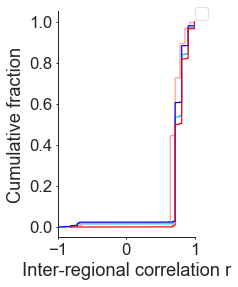

In [28]:
#Cumulative plot showing the probability of all significant inter-regional correlations (Figure 5a)
def df_to_network_self (df):
    df_network = nx.from_pandas_adjacency(df)
    df_network.remove_edges_from(nx.selfloop_edges(df_network))
    return df_network

WT_ctrl_network = df_to_network_self(corr_WT_ctrl)
Tbr1_ctrl_network = df_to_network_self(corr_Tbr1_ctrl)
WT_TBS_network = df_to_network_self(corr_WT_TBS)
Tbr1_TBS_network = df_to_network_self(corr_Tbr1_TBS)

WT_ctrl_network_edge = utils.edge_table(WT_ctrl_network)
Tbr1_ctrl_network_edge = utils.edge_table(Tbr1_ctrl_network)
WT_TBS_network_edge = utils.edge_table(WT_TBS_network)
Tbr1_TBS_network_edge = utils.edge_table(Tbr1_TBS_network)

def even_network_edge_table(edge_table):
    
    edge_table_sub = edge_table.loc[[a for a in edge_table.index if a%2==0]]
    
    return edge_table_sub

WT_ctrl_network_edge_sub = even_network_edge_table(WT_ctrl_network_edge)
Tbr1_ctrl_network_edge_sub = even_network_edge_table(Tbr1_ctrl_network_edge)
WT_TBS_network_edge_sub = even_network_edge_table(WT_TBS_network_edge)
Tbr1_TBS_network_edge_sub = even_network_edge_table(Tbr1_TBS_network_edge)

def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)
    # x-data for the ECDF: x
    x = np.sort(data)
    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y
WT_ctrl_network_edge_x, WT_ctrl_network_edge_y = ecdf (WT_ctrl_network_edge_sub["weight"].tolist())
Tbr1_ctrl_network_edge_x, Tbr1_ctrl_network_edge_y = ecdf (Tbr1_ctrl_network_edge_sub["weight"].tolist())
WT_TBS_network_edge_x, WT_TBS_network_edge_y = ecdf (WT_TBS_network_edge_sub["weight"].tolist())
Tbr1_TBS_network_edge_x, Tbr1_TBS_network_edge_y = ecdf (Tbr1_TBS_network_edge_sub["weight"].tolist())

plt.figure (figsize = (3,4))

plt.plot (WT_ctrl_network_edge_x, WT_ctrl_network_edge_y, c = "#00C8FF")
plt.plot (Tbr1_ctrl_network_edge_x, Tbr1_ctrl_network_edge_y, c  = "#FF9E8B")
plt.plot (WT_TBS_network_edge_x, WT_TBS_network_edge_y, c = "#0000FF")
plt.plot (Tbr1_TBS_network_edge_x, Tbr1_TBS_network_edge_y, c = "#FF0000")
plt.xlim([-1, 1])
plt.xlabel("Inter-regional correlation r")
plt.ylabel("Cumulative fraction")
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[:], labels[:], bbox_to_anchor=(1, 1.02), loc=2, borderaxespad=0.)
plt.tight_layout()
sns.despine()
plt.show()

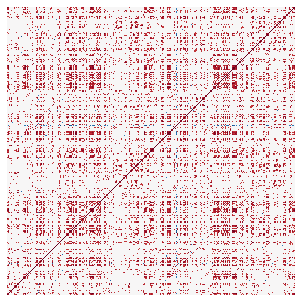

In [16]:
#plot correlation martix
#Example: WT ctrl (Figure 5b left panel)
plt.figure (figsize = (4,4))
ax = sns.heatmap (corr_WT_ctrl, cmap = "RdBu_r", vmin=-1, vmax=1, center = 0,
                  square = True, cbar = False, cbar_kws={"shrink": 0.5, "label": "r value"})
ax.invert_xaxis()
plt.xticks([])
plt.yticks([])
plt.tight_layout(pad =0)
plt.show()

In [47]:
#setting specific structure list for community analysis

structure_list = pd.read_csv ("CCFv3/structuretree/structure_list_paper_cfos.csv", index_col = 0)["LABEL"].tolist()

def community_subset_structure_list (subset_list):
    """subset_list to generate i_ and c_ structure sublist"""
    structure_rearrange_L = []
    structure_rearrange_R = []
    for a in corr_WT_ctrl.index.tolist():
        if (a[:2]=="c_") & (a[2:] in subset_list):
            structure_rearrange_L.append(a)
        elif (a[:2]=="i_") & (a[2:] in subset_list):
            structure_rearrange_R.append(a)
    subset_structure_list = structure_rearrange_R+ structure_rearrange_L
    return subset_structure_list

community_all = community_subset_structure_list(structure_list)

In [ ]:
#determine best resolution r for community detection

np.random.seed(17)
def calculate_Q_diff (df, structure_list):
    r_list = np.arange(0.4, 1, 0.1)
    sum_q_list = []
    diff_q_total = []
    df_sub = df.loc[structure_list, structure_list]
    df_sub_network = nx.from_pandas_adjacency(df_sub)
    df_sub_network.remove_edges_from(nx.selfloop_edges(df_sub_network))

    for a in r_list:
        df_sub_communities = community.louvain_communities(df_sub_network, resolution = a)
        df_sub_q= community.modularity (df_sub_network, df_sub_communities)
        diff_q_list = np.empty(1000)
        for i in tqdm(range (1000)):  
            df_perm = pd.DataFrame(data=df_sub.values, index = np.random.permutation(community_all), columns = np.random.permutation(community_all))  
            df_perm_network = nx.from_pandas_adjacency(df_perm)
            df_perm_network.remove_edges_from(nx.selfloop_edges(df_perm_network))
            df_perm_communities = community.louvain_communities(df_perm_network, resolution = a)
            df_perm_q= community.modularity (df_perm_network, df_perm_communities)
            difference_q = df_sub_q - df_perm_q
            diff_q_list[i]=difference_q

        diff_q_total.append(list(diff_q_list))

    pd_r = pd.DataFrame (data = diff_q_total, index = r_list)
    return pd_r


WT_ctrl_q_diff = calculate_Q_diff(corr_WT_ctrl, community_all)
Tbr1_ctrl_q_diff = calculate_Q_diff(corr_Tbr1_ctrl, community_all)
WT_TBS_q_diff = calculate_Q_diff(corr_WT_TBS, community_all)
Tbr1_TBS_q_diff = calculate_Q_diff(corr_Tbr1_TBS, community_all)

WT_ctrl_q_diff.to_csv("correlation/WT_ctrl_community_Q_r.csv")
Tbr1_ctrl_q_diff.to_csv("correlation/Tbr1_ctrl_community_Q_r.csv")
WT_TBS_q_diff.to_csv("correlation/WT_TBS_community_Q_r.csv")
Tbr1_TBS_q_diff.to_csv("correlation/Tbr1_TBS_community_Q_r.csv")

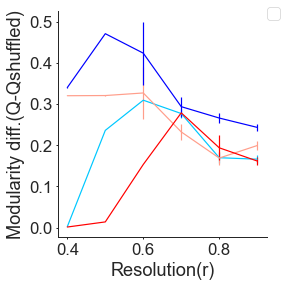

In [96]:
#plot Q difference of C-FOS correlation network (Figure 6a)

WT_ctrl_q_diff = pd.read_csv("correlation/WT_ctrl_community_Q_r.csv", index_col =0)
Tbr1_ctrl_q_diff = pd.read_csv("correlation/Tbr1_ctrl_community_Q_r.csv", index_col =0)
WT_TBS_q_diff = pd.read_csv("correlation/WT_TBS_community_Q_r.csv", index_col =0)
Tbr1_TBS_q_diff = pd.read_csv("correlation/Tbr1_TBS_community_Q_r.csv", index_col =0)

plt.figure (figsize = (4,4))

plt.errorbar (WT_ctrl_q_diff.index.tolist(), WT_ctrl_q_diff.mean(axis = 1).tolist(), WT_ctrl_q_diff.std(axis=1).tolist(), c = "#00C8FF", label = "WT ctrl")

plt.errorbar (Tbr1_ctrl_q_diff.index.tolist(), Tbr1_ctrl_q_diff.mean(axis = 1).tolist(), Tbr1_ctrl_q_diff.std(axis=1).tolist(), c = "#FF9E8B", label = "Tbr1 ctrl")

plt.errorbar (WT_TBS_q_diff.index.tolist(), WT_TBS_q_diff.mean(axis = 1).tolist(), WT_TBS_q_diff.std(axis=1).tolist(), c = "#0000FF", label = "WT TBS")

plt.errorbar (Tbr1_TBS_q_diff.index.tolist(), Tbr1_TBS_q_diff.mean(axis = 1).tolist(), Tbr1_TBS_q_diff.std(axis=1).tolist(), c = "#FF0000", label = "Tbr1 TBS")
plt.xlabel("Resolution(r)")
plt.ylabel("Modularity diff.(Q-Qshuffled)")
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[0:0], labels[0:0], bbox_to_anchor=(1, 1.02), loc=2, borderaxespad=0.)
plt.tight_layout()
sns.despine()
plt.show()

In [107]:
#add additional information to C-FOS correlation martix
corr_WT_ctrl["Group"] = "WT_ctrl"
corr_Tbr1_ctrl["Group"] = "Tbr1_ctrl"
corr_WT_TBS["Group"] = "WT_TBS"
corr_Tbr1_TBS["Group"] = "Tbr1_TBS"

corr = pd.concat([corr_WT_ctrl, corr_Tbr1_ctrl, corr_WT_TBS, corr_Tbr1_TBS])

hemisphere_list = []
for b in corr.index.tolist():
    if b[:2]=="i_":
        hemisphere = "ipsi"
    else:
        hemisphere = "contra"
    hemisphere_list.append (hemisphere)

corr["hemisphere"] = hemisphere_list
corr["structure"] = [a[2:] for a in corr.index.tolist()]

WT_ctrl_i = corr[(corr["Group"]=="WT_ctrl") & (corr["hemisphere"]=="ipsi")]
WT_ctrl_i_average_cfos = W_cfos_R_ctrl_raw["average"].loc[WT_ctrl_i["structure"]]
Tbr1_ctrl_i = corr[(corr["Group"]=="Tbr1_ctrl") & (corr["hemisphere"]=="ipsi")]
Tbr1_ctrl_i_average_cfos = T_cfos_R_ctrl_raw["average"].loc[Tbr1_ctrl_i["structure"]]
WT_TBS_i = corr[(corr["Group"]=="WT_TBS") & (corr["hemisphere"]=="ipsi")]
WT_TBS_i_average_cfos = W_cfos_R_TBS_raw["average"].loc[WT_TBS_i["structure"]]
Tbr1_TBS_i = corr[(corr["Group"]=="Tbr1_TBS") & (corr["hemisphere"]=="ipsi")]
Tbr1_TBS_i_average_cfos = T_cfos_R_TBS_raw["average"].loc[Tbr1_TBS_i["structure"]]
WT_ctrl_c = corr[(corr["Group"]=="WT_ctrl") & (corr["hemisphere"]=="contra")]
WT_ctrl_c_average_cfos = W_cfos_L_ctrl_raw["average"].loc[WT_ctrl_c["structure"]]
Tbr1_ctrl_c = corr[(corr["Group"]=="Tbr1_ctrl") & (corr["hemisphere"]=="contra")]
Tbr1_ctrl_c_average_cfos = T_cfos_L_ctrl_raw["average"].loc[Tbr1_ctrl_c["structure"]]
WT_TBS_c = corr[(corr["Group"]=="WT_TBS") & (corr["hemisphere"]=="contra")]
WT_TBS_c_average_cfos = W_cfos_L_TBS_raw["average"].loc[WT_TBS_c["structure"]]
Tbr1_TBS_c = corr[(corr["Group"]=="Tbr1_TBS") & (corr["hemisphere"]=="contra")]
Tbr1_TBS_c_average_cfos = T_cfos_L_TBS_raw["average"].loc[Tbr1_TBS_c["structure"]]

average_cfos = pd.concat ([WT_ctrl_i_average_cfos, Tbr1_ctrl_i_average_cfos, 
                           WT_TBS_i_average_cfos, Tbr1_TBS_i_average_cfos, 
                           WT_ctrl_c_average_cfos, Tbr1_ctrl_c_average_cfos,
                           WT_TBS_c_average_cfos, Tbr1_TBS_c_average_cfos])

corr["average C-FOS_density sum(cells/mm^3)"] = average_cfos.tolist()

#construct structure color map
structure_list_parent_v1 = pd.read_csv ("CCFv3/structuretree/structure_list_paper_cfos.csv", index_col = 0)

def structure_color_code (df):
    """construct structure color map"""
    cfos_structure_list = list(df["structure"])
    label_list = list(structure_list_parent_v1["LABEL"])
    label_dict = {si : i for i,si in enumerate(label_list)}
    index_list = list(itemgetter(*cfos_structure_list)(label_dict))
    color_list = structure_list_parent_v1.iloc[index_list][['-R-','-G-','-B-']]
    color_tuple = [tuple(x) for x in color_list.to_numpy()]
    color_code = ['#%02x%02x%02x' % (x) for x in color_tuple]

    return color_code
corr["color"] = structure_color_code(corr)

#normalize spot size for network plotting
def normalize_spot_size (spot, scale_level):
    """normalize spot size for static 3d scatter plot"""
    max_size = spot["average C-FOS_density sum(cells/mm^3)"].max()
    
    norm_size = ((spot["average C-FOS_density sum(cells/mm^3)"]/(max_size))*scale_level)+(scale_level/2)
    
    return norm_size

WT_ctrl_corr = corr[corr["Group"]=="WT_ctrl"]
Tbr1_ctrl_corr = corr[corr["Group"]=="Tbr1_ctrl"]
WT_TBS_corr = corr[corr["Group"]=="WT_TBS"]
Tbr1_TBS_corr = corr[corr["Group"]=="Tbr1_TBS"]

WT_ctrl_corr["norm_size"] = normalize_spot_size(WT_ctrl_corr, 10)
Tbr1_ctrl_corr["norm_size"] = normalize_spot_size(Tbr1_ctrl_corr, 10)
WT_TBS_corr["norm_size"] = normalize_spot_size(WT_TBS_corr, 10)
Tbr1_TBS_corr["norm_size"] = normalize_spot_size(Tbr1_TBS_corr, 10)

#add area
structure_list = list(WT_ctrl_corr["structure"])
label_list = list(structure_list_parent_v1["LABEL"])
label_dict = {si : i for i,si in enumerate(label_list)}
index_list = list(itemgetter(*structure_list)(label_dict))
WT_ctrl_corr["area"] = structure_list_parent_v1.iloc[index_list]["area"].tolist()
Tbr1_ctrl_corr["area"] = structure_list_parent_v1.iloc[index_list]["area"].tolist()
WT_TBS_corr["area"] = structure_list_parent_v1.iloc[index_list]["area"].tolist()
Tbr1_TBS_corr["area"] = structure_list_parent_v1.iloc[index_list]["area"].tolist()



In [112]:
#community detection

def community_network (df, subset_list, group, r):
    """detect communities of C-FOS correlation networks"""
           
    sub_df = df.loc[subset_list, subset_list]
    sub_df["color"] = df.loc[subset_list]["color"]
    sub_df["average C-FOS_density sum(cells/mm^3)"] = df.loc[subset_list]["average C-FOS_density sum(cells/mm^3)"]
    sub_df["hemisphere"] = df.loc[subset_list]["hemisphere"]
    sub_df["norm_size"] = df.loc[subset_list]["norm_size"]
    sub_df["structure"] = df.loc[subset_list]["structure"]
    sub_df["area"] = df.loc[subset_list]["area"]
    sub_df["Group"] = df.loc[subset_list]["Group"]
    structure_order = sub_df.index.tolist()
    
    def df_to_network (sub_df):
        df_network = nx.from_pandas_adjacency(sub_df.iloc[:, :-7])
        df_network.remove_edges_from(nx.selfloop_edges(df_network))
        for n, d in df_network.nodes(data = True):

            d["node_color"]= sub_df["color"][n]
            d["density"] = sub_df["average C-FOS_density sum(cells/mm^3)"][n]
            d["hemisphere"]=sub_df["hemisphere"][n]
            d["norm_size"] = sub_df["norm_size"][n]/5
            d["structure"] = sub_df["structure"][n]
            d["area"] = sub_df["area"][n]
            d["specific_structure"]=n
        return df_network
    
    pd_network = df_to_network (sub_df)
    dict_degree_centrality = nx.degree_centrality(pd_network)   
    sub_df["degree_centrality"]= dict_degree_centrality.values()  
    communities = community.louvain_communities(pd_network, resolution = r, seed = 17)
    comms = {}
    for a in communities:
        dictionary = dict.fromkeys(a, communities.index(a))
        comms.update (dictionary)
    comms = {k: comms[k] for k in structure_order}
    sub_df["communities"]= comms.values()
    unique_coms = np.unique(list(comms.values()))
    sub_df.to_csv ("correlation/"+group+".csv")
    
community_network (WT_ctrl_corr, community_all, "WT_ctrl", 0.6)
community_network (Tbr1_ctrl_corr, community_all, "Tbr1_ctrl", 0.6)
community_network (WT_TBS_corr, community_all, "WT_TBS", 0.5)
community_network (Tbr1_TBS_corr, community_all, "Tbr1_TBS", 0.7)

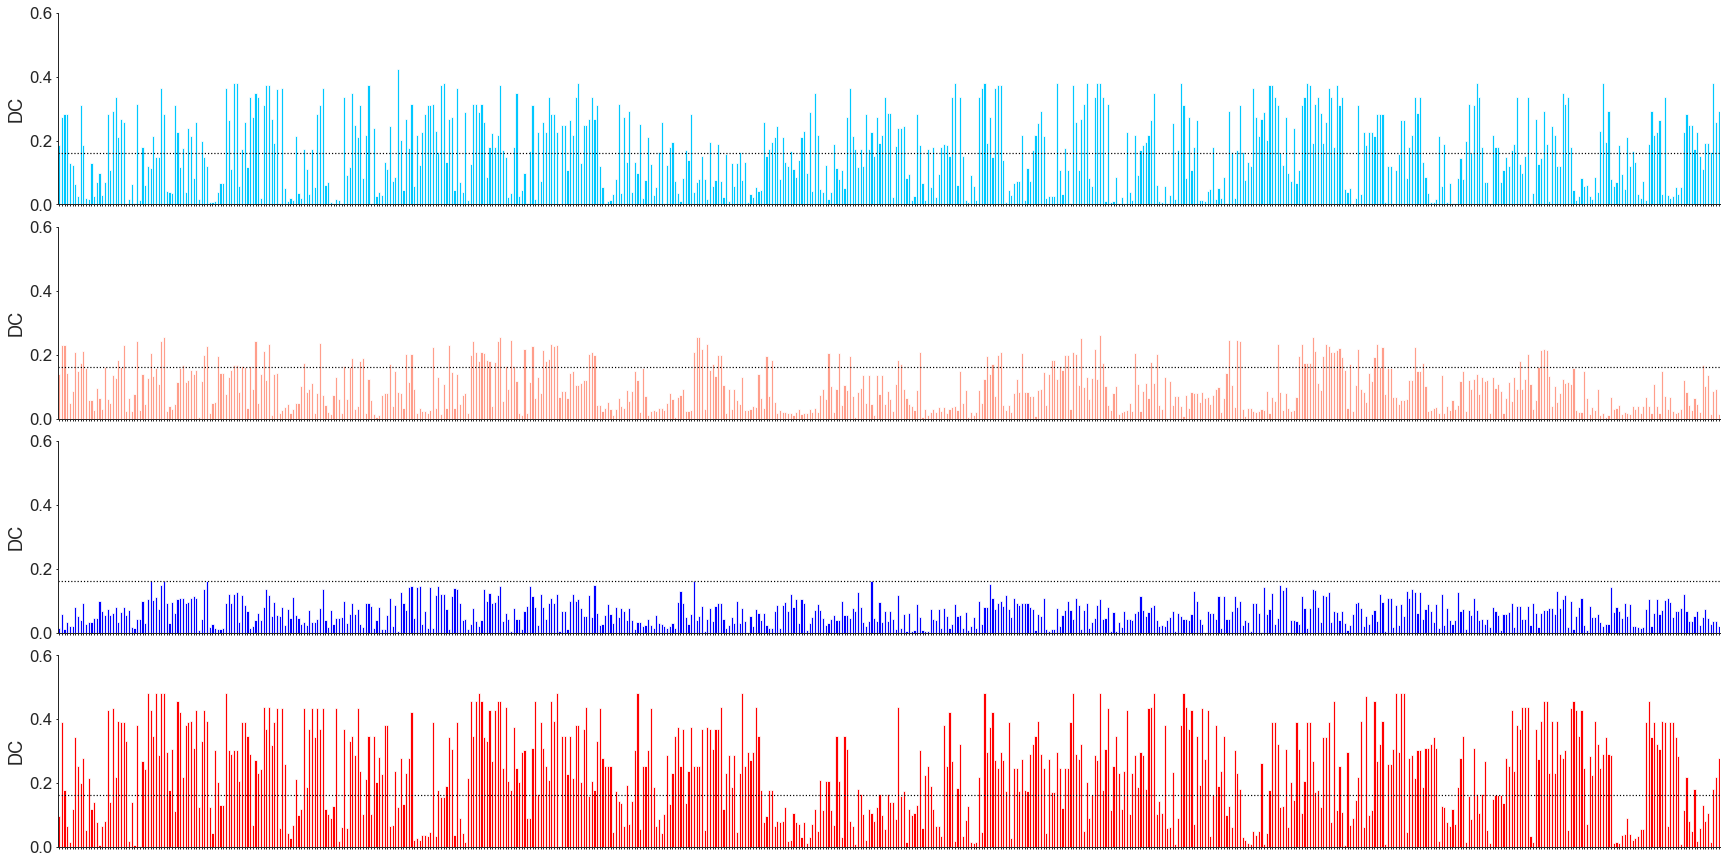

In [27]:
#Plots showing Degree Centrality (DC, y-axis) of each brain region (Figure 5c)

#loading C-FOS correlation martix 
WT_ctrl_com = pd.read_csv ("correlation/WT_ctrl.csv", index_col = 0)
Tbr1_ctrl_com = pd.read_csv ("correlation/Tbr1_ctrl.csv", index_col = 0)
WT_TBS_com = pd.read_csv ("correlation/WT_TBS.csv", index_col = 0)
Tbr1_TBS_com = pd.read_csv ("correlation/Tbr1_TBS.csv", index_col = 0)

WT_ctrl_average_centrility = WT_ctrl_com["degree_centrality"].mean()

plt.figure (figsize =(24, 12))

plt.subplot(4, 1, 1)
sns.barplot (x=WT_ctrl_com.index.tolist(), y =WT_ctrl_com["degree_centrality"].tolist(), color = "#00C8FF", saturation=1)
plt.ylim(0, 0.6)
plt.axhline(y = WT_ctrl_average_centrility, color='black', linestyle=':')
plt.ylabel("DC")
ax = plt.gca()
ax.tick_params(labelbottom = False)
ax.invert_xaxis()

plt.subplot(4, 1, 2)
sns.barplot (x=Tbr1_ctrl_com.index.tolist(), y =Tbr1_ctrl_com["degree_centrality"].tolist(), color = "#FF9E8B", saturation=1)
plt.ylim(0, 0.6)
plt.axhline(y = WT_ctrl_average_centrility, color='black', linestyle=':')
plt.ylabel("DC")
ax = plt.gca()
ax.tick_params(labelbottom = False)
ax.invert_xaxis()

plt.subplot(4, 1, 3)
sns.barplot (x=WT_TBS_com.index.tolist(), y =WT_TBS_com["degree_centrality"].tolist(), color = "#0000FF", saturation=1)
plt.ylim(0, 0.6)
plt.axhline(y = WT_ctrl_average_centrility, color='black', linestyle=':')
plt.ylabel("DC")
ax = plt.gca()
ax.tick_params(labelbottom = False)
ax.invert_xaxis()

plt.subplot(4, 1, 4)
sns.barplot (x=Tbr1_TBS_com.index.tolist(), y =Tbr1_TBS_com["degree_centrality"].tolist(), color = "#FF0000", saturation=1)
plt.ylim(0, 0.6)
plt.axhline(y = WT_ctrl_average_centrility, color='black', linestyle=':')
plt.ylabel("DC")
ax = plt.gca()
ax.tick_params(labelbottom = False)
ax.invert_xaxis()
sns.despine()
plt.tight_layout()
plt.show()

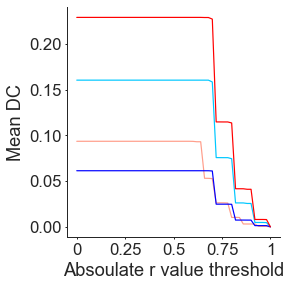

In [32]:
#varify r value threshold to examine network stability (Figure 5d upper panel)

WT_ctrl_corr = WT_ctrl_com.loc[WT_ctrl_com.index, WT_ctrl_com.index]
Tbr1_ctrl_corr = Tbr1_ctrl_com.loc[Tbr1_ctrl_com.index, Tbr1_ctrl_com.index]
WT_TBS_corr = WT_TBS_com.loc[WT_TBS_com.index, WT_TBS_com.index]
Tbr1_TBS_corr = Tbr1_TBS_com.loc[Tbr1_TBS_com.index, Tbr1_TBS_com.index]

r_list = np.arange(0, 1.02, 0.02)

mean_WT_ctrl_degree_centrality_list = []
mean_Tbr1_ctrl_degree_centrality_list = []
mean_WT_TBS_degree_centrality_list = []
mean_Tbr1_TBS_degree_centrality_list = []
for a in r_list:
    WT_ctrl_corr_new = WT_ctrl_corr*(WT_ctrl_corr>a)
    Tbr1_ctrl_corr_new = Tbr1_ctrl_corr*(Tbr1_ctrl_corr>a)
    WT_TBS_corr_new = WT_TBS_corr*(WT_TBS_corr>a)
    Tbr1_TBS_corr_new = Tbr1_TBS_corr*(Tbr1_TBS_corr>a)

    WT_ctrl_new_network = df_to_network_self(WT_ctrl_corr_new)
    dict_WT_ctrl_degree_centrality = nx.degree_centrality(WT_ctrl_new_network)
    mean_WT_ctrl_degree_centrality = np.mean([values for keys, values in dict_WT_ctrl_degree_centrality.items()])
    mean_WT_ctrl_degree_centrality_list.append(mean_WT_ctrl_degree_centrality)
    
    Tbr1_ctrl_new_network = df_to_network_self(Tbr1_ctrl_corr_new)
    dict_Tbr1_ctrl_degree_centrality = nx.degree_centrality(Tbr1_ctrl_new_network)
    mean_Tbr1_ctrl_degree_centrality = np.mean([values for keys, values in dict_Tbr1_ctrl_degree_centrality.items()])
    mean_Tbr1_ctrl_degree_centrality_list.append(mean_Tbr1_ctrl_degree_centrality)

    WT_TBS_new_network = df_to_network_self(WT_TBS_corr_new)
    dict_WT_TBS_degree_centrality = nx.degree_centrality(WT_TBS_new_network)
    mean_WT_TBS_degree_centrality = np.mean([values for keys, values in dict_WT_TBS_degree_centrality.items()])
    mean_WT_TBS_degree_centrality_list.append(mean_WT_TBS_degree_centrality)
    
    Tbr1_TBS_new_network = df_to_network_self(Tbr1_TBS_corr_new)
    dict_Tbr1_TBS_degree_centrality = nx.degree_centrality(Tbr1_TBS_new_network)
    mean_Tbr1_TBS_degree_centrality = np.mean([values for keys, values in dict_Tbr1_TBS_degree_centrality.items()])
    mean_Tbr1_TBS_degree_centrality_list.append(mean_Tbr1_TBS_degree_centrality)

plt.figure (figsize =(4, 4))

plt.plot(r_list, mean_WT_ctrl_degree_centrality_list, c =  "#00C8FF")
plt.plot(r_list, mean_Tbr1_ctrl_degree_centrality_list, c =  "#FF9E8B")
plt.plot(r_list, mean_WT_TBS_degree_centrality_list, c =  "#0000FF")
plt.plot(r_list, mean_Tbr1_TBS_degree_centrality_list, c =  "#FF0000")
plt.xlabel("Absoulate r value threshold")
plt.ylabel("Mean DC")
new_xticks = np.linspace(0, 1, 5)
plt.xticks(new_xticks,[0, 0.25, 0.5, 0.75, 1], rotation=0)
sns.despine()
plt.tight_layout()
plt.show()

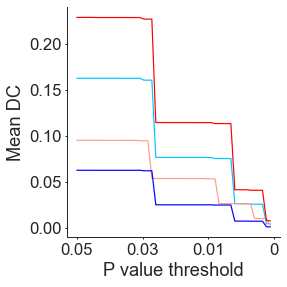

In [35]:
#varify P value threshold to examine network stability (Figure 5d lower panel)

P_WT_ctrl = pd.read_csv ("correlation/P_WT_ctrl.csv", index_col =0)
P_Tbr1_ctrl= pd.read_csv ("correlation/P_Tbr1_ctrl.csv", index_col =0)
P_WT_TBS= pd.read_csv ("correlation/P_WT_TBS.csv", index_col =0)
P_Tbr1_TBS= pd.read_csv ("correlation/P_Tbr1_TBS.csv", index_col =0)

P_list = np.arange(0.001,0.051, 0.001)
mean_WT_ctrl_degree_centrality_list = []
mean_Tbr1_ctrl_degree_centrality_list = []
mean_WT_TBS_degree_centrality_list = []
mean_Tbr1_TBS_degree_centrality_list = []
for a in P_list:
    WT_ctrl_corr_new = WT_ctrl_corr*(P_WT_ctrl<a)
    Tbr1_ctrl_corr_new = Tbr1_ctrl_corr*(P_Tbr1_ctrl<a)
    WT_TBS_corr_new = WT_TBS_corr*(P_WT_TBS<a)
    Tbr1_TBS_corr_new = Tbr1_TBS_corr*(P_Tbr1_TBS<a)

    WT_ctrl_new_network = df_to_network_self(WT_ctrl_corr_new)
    dict_WT_ctrl_degree_centrality = nx.degree_centrality(WT_ctrl_new_network)
    mean_WT_ctrl_degree_centrality = np.mean([values for keys, values in dict_WT_ctrl_degree_centrality.items()])
    mean_WT_ctrl_degree_centrality_list.append(mean_WT_ctrl_degree_centrality)
    
    Tbr1_ctrl_new_network = df_to_network_self(Tbr1_ctrl_corr_new)
    dict_Tbr1_ctrl_degree_centrality = nx.degree_centrality(Tbr1_ctrl_new_network)
    mean_Tbr1_ctrl_degree_centrality = np.mean([values for keys, values in dict_Tbr1_ctrl_degree_centrality.items()])
    mean_Tbr1_ctrl_degree_centrality_list.append(mean_Tbr1_ctrl_degree_centrality)

    WT_TBS_new_network = df_to_network_self(WT_TBS_corr_new)
    dict_WT_TBS_degree_centrality = nx.degree_centrality(WT_TBS_new_network)
    mean_WT_TBS_degree_centrality = np.mean([values for keys, values in dict_WT_TBS_degree_centrality.items()])
    mean_WT_TBS_degree_centrality_list.append(mean_WT_TBS_degree_centrality)
    
    Tbr1_TBS_new_network = df_to_network_self(Tbr1_TBS_corr_new)
    dict_Tbr1_TBS_degree_centrality = nx.degree_centrality(Tbr1_TBS_new_network)
    mean_Tbr1_TBS_degree_centrality = np.mean([values for keys, values in dict_Tbr1_TBS_degree_centrality.items()])
    mean_Tbr1_TBS_degree_centrality_list.append(mean_Tbr1_TBS_degree_centrality)
    
plt.figure (figsize =(4, 4))

plt.plot(P_list, mean_WT_ctrl_degree_centrality_list, c =  "#00C8FF")
plt.plot(P_list, mean_Tbr1_ctrl_degree_centrality_list, c =  "#FF9E8B")
plt.plot(P_list, mean_WT_TBS_degree_centrality_list, c =  "#0000FF")
plt.plot(P_list, mean_Tbr1_TBS_degree_centrality_list, c =  "#FF0000")
plt.xlabel("P value threshold")
plt.ylabel("Mean DC")
new_xticks = np.linspace(0, 0.05, 4)
plt.xticks(new_xticks,[0,0.01, 0.03, 0.05], rotation=0)
ax = plt.gca()
ax.invert_xaxis()
sns.despine()
plt.tight_layout()
plt.show()

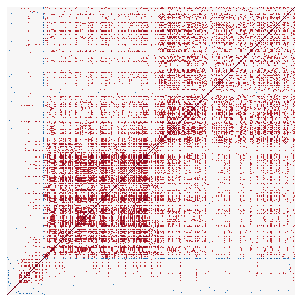

In [38]:
#C-FOS correlation martix (sorted by communities)
#ploting Example: Figure 6b WT ctrl
def rearange_community (df):
    """rearange community and community color"""
    community_new = []
    df_new = df.copy()
    for b in df.index:
        if b in df_new.index:
            lead_group = df.loc[b, "communities"]
            group = df[df["communities"]==lead_group].index.tolist()
            community_new.append(group)
            df_new.drop (index = group, inplace = True)

    for c in np.arange(len(community_new)):
        df.loc[community_new[c], "new_communities"]=c

    kelly_palette = ["#F3C300", "#875692", "#F38400", "#A1CAF1", "#BE0032", "#C2B280",
                        "#008856", "#E68FAC", "#0067A5", "#F99379", "#604E97", 
                        "#F6A600", "#B3446C", "#DCD300", "#882D17", "#8DB600", "#654522", 
                        "#E25822", "#2B3D26", "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", 
                        "#9467bd", "#8c564b", "#e377c2", "#bcbd22", "#17becf"]

    unique_community = np.arange(len(community_new))

    community_color_dict = {unique_community[i]:kelly_palette[i] for i in unique_community}
    color_code = list(itemgetter(*list(df["new_communities"]))(community_color_dict))
    df["new_communities_color"]=color_code

rearange_community(WT_ctrl_com)
rearange_community(Tbr1_ctrl_com)
rearange_community(WT_TBS_com)
rearange_community(Tbr1_TBS_com)

#plot rearanged correlation martix
def rearange_martix (df, column_name):
    rearange_index = df.sort_values(by=[column_name]).index.tolist()
    return df.loc[rearange_index,rearange_index]

plt.figure (figsize = (4,4))

ax = sns.heatmap (rearange_martix(WT_ctrl_com, "new_communities"), cmap = "RdBu_r", vmin=-1, vmax=1, center = 0,
                  square = True, cbar_kws={"shrink": 0.5, "label": "r value"}, cbar = False)
ax.invert_xaxis()
plt.xticks([])
plt.yticks([])
plt.tight_layout(pad =0)
plt.show()

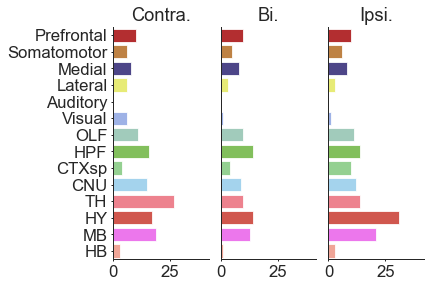

In [42]:
#EDA of community: calculate brain region numbers among major brain areas
#Ploting example: Figure s9 WT ctrl community1

community1 = WT_ctrl_com[WT_ctrl_com["new_communities"]==0].index.tolist()
community2 = WT_ctrl_com[WT_ctrl_com["new_communities"]==1].index.tolist()
community3 = WT_ctrl_com[WT_ctrl_com["new_communities"]==2].index.tolist()
other_community = WT_ctrl_com[WT_ctrl_com["new_communities"].isin([3,4,5,6,7,8,9,10,11,12,13])].index.tolist()

area_list = ["Prefrontal", "Somatomotor", "Medial", "Lateral", "Auditory", "Visual", "Olfactory areas", "Hippocampal formation", "Cortical subplate", 
                     "Cerebral nuclei", "Thalamus", "Hypothalamus", "Midbrain", "Hindbrain"]

area_color = ["#C9181B", "#D28230", "#453B93", "#F9FF62", "#5C2E84", "#92ACF2", "#9AD2BD", "#7ED04B", "#8ADA87", "#98D6F9", "#FF7080", "#E64438",
                      "#FF64FF", "#FF9B88"]

def EDA_community (df, community, community_name):
    contra_com = [s for s in community if s[:1]=="c"]
    ipsi_com = [s for s in community if s[:1]=="i"]
    network_sub_contra = df.loc[contra_com]
    network_sub_ipsi = df.loc[ipsi_com]

    contra_num_list =[] 
    ipsi_num_list =[]
    bilateral_num_list=[]
    for a in area_list:
        contra_num = len(network_sub_contra[network_sub_contra["area"]==a])
        ipsi_num = len(network_sub_ipsi[network_sub_ipsi["area"]==a])
        contra_num_list.append(contra_num)
        ipsi_num_list.append(ipsi_num)
        bilateral_contra = [s[2:] for s in network_sub_contra[network_sub_contra["area"]==a].index.tolist()]
        bilateral_ipsi = [s[2:] for s in network_sub_ipsi[network_sub_ipsi["area"]==a].index.tolist()]
        bilateral_com = len(list(set(bilateral_contra).intersection(set(bilateral_ipsi))))
        bilateral_num_list.append(bilateral_com)

    pd_community = pd.DataFrame({"contra_num":contra_num_list,
                                        "ipsi_num":ipsi_num_list,
                                        "bilateral_num":bilateral_num_list, 
                                        "color":area_color},
                                        index = area_list)
    pd_community["community"]=community_name

    return pd_community

pd_WT_ctrl_community1 = EDA_community(WT_ctrl_com, community1, "WT_ctrl_community1")

#plotting figure
plt.figure (figsize =(6,4))
def bar_plot_EDA_community (pd_community):

    plt.subplot(1, 3, 1)
    sns.barplot(x = pd_community["contra_num"].tolist(), y = pd_community.index.tolist(), palette= pd_community["color"].tolist(), orient= "h")
    plt.xlim(0, 42)
    ax = plt.gca()
    ax.set_yticklabels(["Prefrontal", "Somatomotor", "Medial", "Lateral", "Auditory", "Visual", "OLF", "HPF", "CTXsp", "CNU", "TH", "HY", "MB", "HB"])
    plt.title("Contra.")

    plt.subplot(1, 3, 2)
    sns.barplot(x = pd_community["bilateral_num"].tolist(), y = pd_community.index.tolist(), palette= pd_community["color"].tolist(), orient= "h")
    plt.xlim(0, 42)
    ax = plt.gca()
    ax.tick_params(labelleft = False, left = False)
    plt.title("Bi.")
    plt.subplot(1, 3, 3)
    sns.barplot(x = pd_community["ipsi_num"].tolist(), y = pd_community.index.tolist(), palette= pd_community["color"].tolist(), orient= "h")
    plt.xlim(0, 42)
    ax = plt.gca()
    ax.tick_params(labelleft = False, left = False)
    plt.title("Ipsi.")
    sns.despine()
    plt.tight_layout()

bar_plot_EDA_community(pd_WT_ctrl_community1)
plt.show()

In [44]:
#calculate participation_coefficient

def calculate_participation_coefficient (df, df_network):
    participation_coefficient_list = []
    for n in df.index:
        nbrs = list(df_network.neighbors(n))
        communities_project = df.loc[nbrs]
        communities_project_group = communities_project.groupby (["new_communities"])
        if len(nbrs)!=0:
            ratio_to_sum = [(m/len(nbrs))**2 for m in communities_project_group.size().tolist()]
            participation_coefficient = 1 - sum(ratio_to_sum)
        else:
            participation_coefficient = 0  
        participation_coefficient_list.append(participation_coefficient)
    df["participation_coefficient"] = participation_coefficient_list
    for node, d in df_network.nodes(data = True):
        d["participation_coefficient"] = df["participation_coefficient"][node]


calculate_participation_coefficient (WT_ctrl_com, WT_ctrl_network)
calculate_participation_coefficient (Tbr1_ctrl_com, Tbr1_ctrl_network)
calculate_participation_coefficient (WT_TBS_com, WT_TBS_network)
calculate_participation_coefficient (Tbr1_TBS_com, Tbr1_TBS_network)

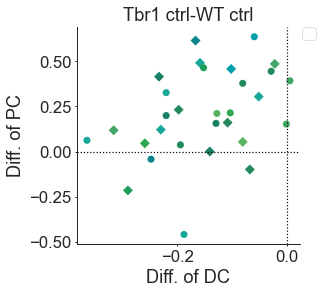

In [52]:
#comparison of centrality and participation coefficient in subset of brain regions
#Example: Figure 7c left panel Tbr1 ctrl – WT ctrl

DMN_list = ["ACAd", "ACAv", "PL", "ILA", "ORBl", "ORBm", "ORBvl", 
            "VISa", "VISam", "RSPagl", "RSPd", "RSPv", 
            "SSp-tr", "SSp-ll", "MOs"]

community_DMN_list = community_subset_structure_list(DMN_list)

def diff_centrality_PC_list (df1, df2, structure_list):
    df1_sub= df1.loc[structure_list]
    df2_sub = df2.loc[structure_list]

    difference_contrality_list = []
    difference_PC_list = []
    for indexa, varaa in df1_sub.iterrows():
        difference_contrality = (df2_sub.loc[indexa, "degree_centrality"])-(df1_sub.loc[indexa, "degree_centrality"])
        difference_PC = (df2_sub.loc[indexa, "participation_coefficient"])-(df1_sub.loc[indexa, "participation_coefficient"])
        difference_contrality_list.append (difference_contrality)
        difference_PC_list.append(difference_PC)

    difference_df = pd.DataFrame ({"structure": df1_sub["structure"].tolist(),
                                   "diff_contrality": difference_contrality_list,
                                   "diff_PC": difference_PC_list, 
                                   "hemisphere": df1_sub["hemisphere"].tolist(),
                                   "area": df1_sub["area"].tolist()})
    structure_list_L = ["LA", "BLA", "amc", "VISam", "CP", "AI", "VISC", "ORBvl", "TEa", "AIp", "ORBl", "ACAd", "BLAa",
                    "AUD", "ACAv", "PL", "ILA", "RSPv", "RSPd", "RSPagl", "VISa", "MOs", "SSp-tr", "SSp-ll", "act", "ORBm", "PP",
                    "CM", "RH", "PCN", "PF", "CL", "PIL", "AUDd", "AUDv", "PVpo",
                    "RSP", "ORB", "ACA", "ILM", "AId", "VTA", "RE", "BLAp"]


    structure_list_R = ["LA", "BLA", "ORBvl", "PBG", "SAG", "FRP", "APr", "VISam", "scp", "CP", "AI", "VISC", "TEa", "AIp", "ORBl", "ACAd", "BLAa",
                        "AUD", "ORBm", "ACAv", "PL", "ILA", "RSPv", "RSPd", "RSPagl", "VISa", "MOs", "SSp-tr", "SSp-ll", "PPN", "PP", "RCH", "ORBm",
                        "CM", "RH", "PCN", "PF", "CL", "PIL", "AUDd", "AUDv", "DG", "VTA",
                        "RSP", "ORB", "ACA", "ILM", "AId", "PVpo", "RE"]
 
    difference_df["ROI correction"] = "No"

    contra_df = difference_df[difference_df["hemisphere"]=="contra"]
    ipsi_df = difference_df[difference_df["hemisphere"]=="ipsi"]

    for a in contra_df.structure:
        if a in structure_list_L:
            contra_df.loc[contra_df[contra_df["structure"]==a].index, "ROI correction"]="Yes"
        
    for b in ipsi_df.structure:
        if b in structure_list_R:
            ipsi_df.loc[ipsi_df[ipsi_df["structure"]==b].index, "ROI correction"]="Yes"
       
    contra_df_new = contra_df.set_axis ([str("c_")+a for a in contra_df.structure.tolist()], axis =0)
    ipsi_df_new = ipsi_df.set_axis ([str("i_")+a for a in ipsi_df.structure.tolist()], axis =0)

    diff_df_new = pd.concat([ipsi_df_new, contra_df_new])

    return diff_df_new

WT_Tbr1_ctrl_diff = diff_centrality_PC_list (WT_ctrl_com, Tbr1_ctrl_com, community_DMN_list)

#calculate color in each brain regions
structure_list_parent_v1 = pd.read_csv ("CCFv3/structuretree/structure_list_paper_cfos.csv", index_col = 0)

def structure_color_dict (df):
    """construct structure color map"""
    cfos_structure_list = list(df["structure"])
    label_list = list(structure_list_parent_v1["LABEL"])
    label_dict = {si : i for i,si in enumerate(label_list)}
    index_list = list(itemgetter(*cfos_structure_list)(label_dict))
    color_list = structure_list_parent_v1.iloc[index_list][['-R-','-G-','-B-']]
    color_tuple = [tuple(x) for x in color_list.to_numpy()]
    color_code = ['#%02x%02x%02x' % (x) for x in color_tuple]
    structure_zip = zip(cfos_structure_list, color_code)
    structure_dict = dict(structure_zip)
    
    return structure_dict

diff_dict = structure_color_dict (WT_Tbr1_ctrl_diff)

#plotting figure
contra_df = WT_Tbr1_ctrl_diff[WT_Tbr1_ctrl_diff["hemisphere"]=="contra"]
ipsi_df = WT_Tbr1_ctrl_diff[WT_Tbr1_ctrl_diff["hemisphere"]=="ipsi"]

ipsi_markers = {"Yes_Tbr1_vol_correlated": "o", "Yes": "o", "No": "$\circ$", "need_correction": "$\circ$"}
contra_markers = {"Yes_Tbr1_vol_correlated": "D", "Yes": "D", "No": "$\diamond$", "need_correction": "$\diamond$"}

plt.figure (figsize = (4,4))
ax = sns.scatterplot (data = contra_df, 
                     x = "diff_contrality",
                     y = "diff_PC", 
                     hue = "structure",
                     palette = diff_dict,
                     style = "ROI correction",
                     markers = contra_markers,
                     legend = False, 
                     s = 50,
                     linewidth=0)
ax = sns.scatterplot (data = ipsi_df, 
                     x = "diff_contrality",
                     y = "diff_PC", 
                     hue = "structure",
                     palette = diff_dict,
                     style = "ROI correction",
                     markers = ipsi_markers,
                     legend = False, 
                     s = 50,
                     linewidth=0)
plt.ylabel ("Diff. of PC")
plt.xlabel ("Diff. of DC")
plt.axhline(y=0, color='black', linestyle=':')
plt.axvline(x=0, color='black', linestyle=':')
plt.title ("Tbr1 ctrl-WT ctrl")
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[:], labels[:], bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
sns.despine()
plt.show()

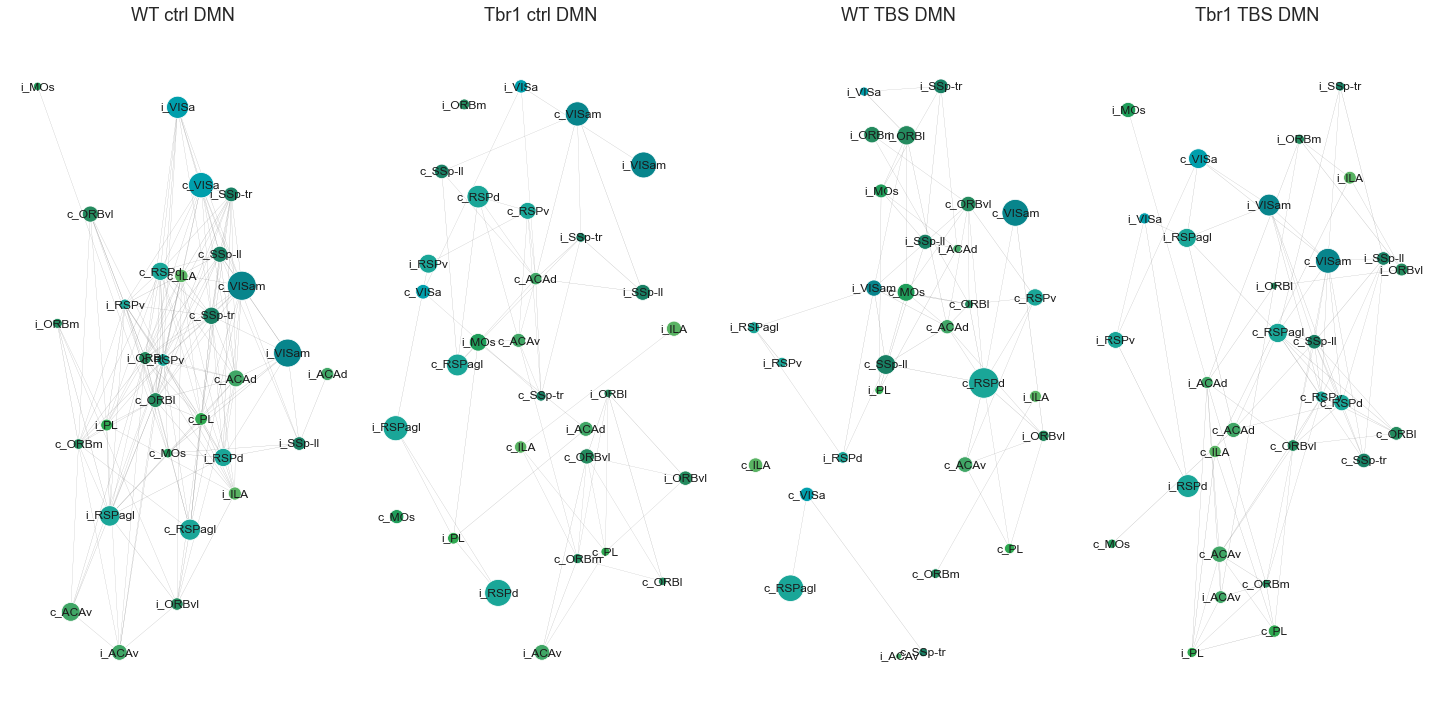

In [59]:
#plot spring layout of DMN network (Figure 7d)
def df_to_network_sp (df):
    df_network = nx.from_pandas_adjacency(df.loc[df.index,df.index])
    df_network.remove_edges_from(nx.selfloop_edges(df_network))
    for n, d in df_network.nodes(data = True):

        d["node_color"]= df["color"][n]
        d["density"] = df["average C-FOS_density sum(cells/mm^3)"][n]
        d["hemisphere"]=df["hemisphere"][n]
        d["norm_size"] = df["norm_size"][n]/5
        d["structure"] = df["structure"][n]
        d["area"]=df["area"][n]      
        d["community"]=df["new_communities"][n]
        d["degree_centrality"]=df["degree_centrality"][n]
        d["communities_color"] = df["new_communities_color"][n]
        d["participation_coefficient"] = df["participation_coefficient"][n]

    return df_network

WT_ctrl_network_sp = df_to_network_sp(WT_ctrl_com)
Tbr1_ctrl_network_sp= df_to_network_sp(Tbr1_ctrl_com)
WT_TBS_network_sp = df_to_network_sp(WT_TBS_com)
Tbr1_TBS_network_sp = df_to_network_sp(Tbr1_TBS_com)

def draw_subgraph_of_interested_nodes (G, interested_nodes_list):
    """draw sub_network graph of interested nodes and one degree progatation"""
    node_set = set(interested_nodes_list)
    G_sub = G.subgraph(node_set)   
    pos = nx.spring_layout(G_sub, k = 1, seed = 18)
    nx.draw(G_sub,
            pos,
            node_size = utils.node_table(G_sub)["density"]/8,
            alpha = 1,
            node_color=utils.node_table(G_sub)["node_color"],
            with_labels = True,
            font_size = 12,
            width = abs(utils.edge_table(G_sub)["weight"])/5,
            edgecolors = "white",
            edge_color = "gray")

plt.figure (figsize = (20,10))
plt.subplot (1,4,1)
draw_subgraph_of_interested_nodes (WT_ctrl_network_sp, community_DMN_list)
plt.title("WT ctrl DMN")
plt.subplot (1,4,2)
draw_subgraph_of_interested_nodes (Tbr1_ctrl_network_sp, community_DMN_list)
plt.title("Tbr1 ctrl DMN")
plt.subplot (1,4,3)
draw_subgraph_of_interested_nodes (WT_TBS_network_sp, community_DMN_list)
plt.title("WT TBS DMN")
plt.subplot (1,4,4)
draw_subgraph_of_interested_nodes (Tbr1_TBS_network_sp, community_DMN_list)
plt.title("Tbr1 TBS DMN")
plt.tight_layout()
plt.show()